# Reimplementing CanICA without nilearn.decompistion.canICA

In [22]:
%matplotlib inline

In [23]:
from nilearn import datasets
#dir='/raid/nilearn_data'
adhd_dataset = datasets.fetch_adhd(n_subjects=1,data_dir='/home/share/TmpData/Qinglin/nilearn_data/')
func_filenames = adhd_dataset.func  # list of 4D nifti files for each subject

# print basic information on the dataset
print('First functional nifti image (4D) is at: %s' %
      func_filenames[0])  # 4D data

First functional nifti image (4D) is at: /home/share/TmpData/Qinglin/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz


/usr/local/lib/python3.5/dist-packages/nilearn/datasets/func.py:503: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)


In [24]:
from nilearn._utils.niimg_conversions import _resolve_globbing
imgs = _resolve_globbing(func_filenames)

In [25]:
from nilearn.masking import compute_epi_mask
mask_img = compute_epi_mask(func_filenames)

from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask_img, 
                     standardize=True,
                     smoothing_fwhm=6.,
                     memory="nilearn_cache", 
                     memory_level=2)
fmri_masked = masker.fit()

/home/uga_qinglin/.local/lib/python3.5/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/usr/local/lib/python3.5/dist-packages/nilearn/_utils/cache_mixin.py:84: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='nilearn_cache'", use "location='nilearn_cache'" instead.
  memory = Memory(cachedir=cache_dir, verbose=verbose)
/usr/local/lib/python3.5/dist-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


In [26]:
fmri_masked

NiftiMasker(detrend=False, dtype=None, high_pass=None, low_pass=None,
      mask_args=None,
      mask_img=<nibabel.nifti1.Nifti1Image object at 0x7fb639e9d748>,
      mask_strategy='background',
      memory=Memory(location=nilearn_cache/joblib), memory_level=2,
      sample_mask=None, sessions=None, smoothing_fwhm=6.0,
      standardize=True, t_r=None, target_affine=None, target_shape=None,
      verbose=0)

In [27]:
from nilearn.decomposition.base import mask_and_reduce

data = mask_and_reduce(
    masker, imgs, confounds=None,
    reduction_ratio=1,
    random_state=0,
    memory="nilearn_cache",
    memory_level=3,
    n_jobs=8)

In [28]:
print(data.shape)

(176, 62546)


In [38]:
# from sklearn.decomposition import FastICA
# ica = FastICA(n_components=10,
#                       random_state=0)
# D=ica.fit_transform(data)
# components=ica.mixing_.T
# print(D.shape)



(176, 10)


In [41]:
from sklearn.decomposition import dict_learning_online
D, components=dict_learning_online(data,n_components=10, alpha=10)
print(D.shape)

(176, 10)


In [11]:
from sklearn.preprocessing import normalize
components=normalize(components, axis=1, copy=True, return_norm=False)
components[abs(components) < 1] = 0

from scipy import stats
components=stats.zscore(components)
components[abs(components) < 1] = 0

for component in components:
    if np.sum(component > 0) < np.sum(component < 0):
        component *= -1

In [42]:
import numpy as np
from scipy.stats import scoreatpercentile
ica_maps=components
ratio=1
abs_ica_maps = np.abs(ica_maps)
threshold = scoreatpercentile(
    abs_ica_maps,
    100. - (100. / len(ica_maps)) * ratio)
ica_maps[abs_ica_maps < threshold] = 0.
components=ica_maps

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


/usr/local/lib/python3.5/dist-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/usr/local/lib/python3.5/dist-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


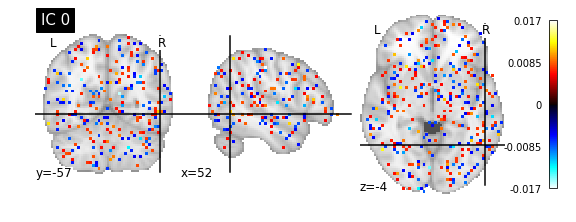

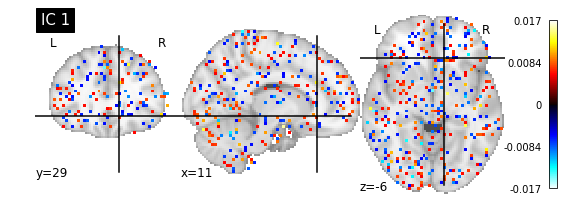

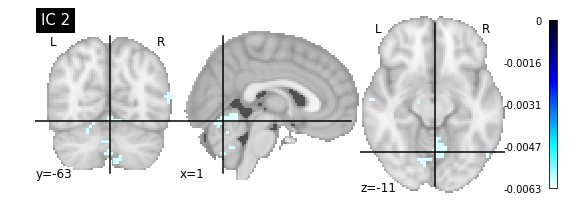

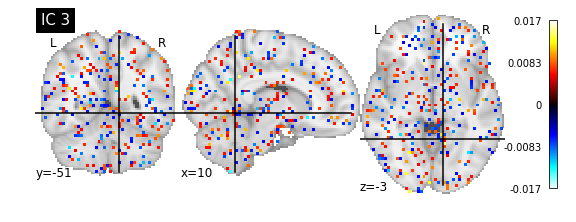

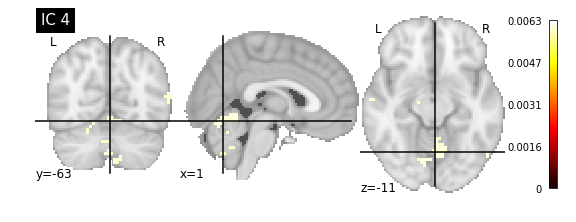

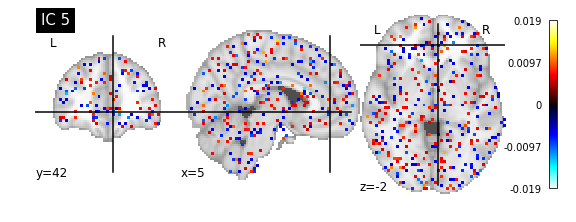

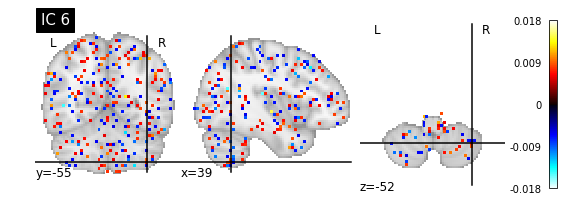

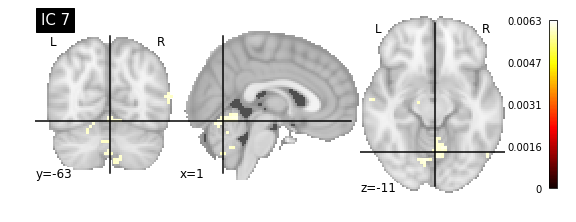

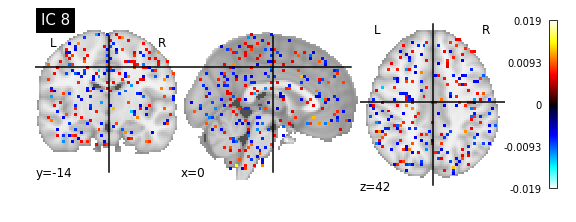

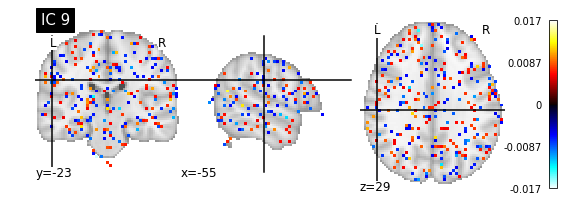

In [43]:
components_img=[masker.inverse_transform(component) for component in components]

from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show

for i, cur_img in enumerate(iter_img(components_img)):
    plot_stat_map(cur_img, display_mode="ortho", title="IC %d" % i,
                  cut_coords=None, colorbar='bwr')

show()